In [1]:
import dask.diagnostics
import faceted
import numpy as np
import xarray as xr

from upath import UPath

import plotting
import utils

In [2]:
plotting.configure_style()

In [3]:
REFERENCE_ROOT = UPath(
    "gs://vcm-ml-raw-flexible-retention/2024-07-03-C96-SHiELD-SOM/regridded-zarrs/gaussian_grid_180_by_360/radiation-multi-call"
)
BASELINE_ROOT = UPath(
    "gs://vcm-ml-raw-flexible-retention/2024-11-11-C24-SHiELD-SOM-tuned-cdmbgwd/regridded-zarrs/gaussian_grid_45_by_90/radiation-multi-call"
)

In [4]:
FACTORS = [0.5, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 8.0, 1.0]
FLUXES = ["DLWRFsfc", "ULWRFsfc", "DSWRFsfc", "USWRFsfc", "ULWRFtoa", "USWRFtoa"]

In [5]:
def unpack_multi_call_diagnostics(ds, factors):
    datasets = {}
    for index, factor in enumerate(factors, start=1):
        fluxes_for_factor = []
        for flux in FLUXES:
            name = f"{flux}_with_scaled_co2_{index}"
            fluxes_for_factor.append(ds[name].rename(flux))
        datasets[factor] = xr.merge(fluxes_for_factor)
    return utils.dict_to_dataset(datasets, dim="factor").sortby("factor")


def open_multi_call_diagnostics(root, factors):
    multi_call = xr.open_zarr(root / "radiation_multi_call_diagnostics.zarr")
    base = xr.open_zarr(root / "fluxes_2d.zarr")

    base_as_multi_call = []
    for flux in FLUXES:
        renamed = base[flux].rename(f"{flux}_with_scaled_co2_{len(factors)}")
        base_as_multi_call.append(renamed)
    base_as_multi_call = xr.merge(base_as_multi_call)
    ds = xr.merge([multi_call, base_as_multi_call])
    ds = unpack_multi_call_diagnostics(ds, factors)
    time_mean = ds.isel(time=slice(1460, None)).mean("time")
    return time_mean.weighted(np.cos(np.deg2rad(time_mean.grid_yt))).mean(
        ["grid_xt", "grid_yt"]
    )


def open_multi_call_ace_diagnostics(beaker_dataset_id, factors):
    time_mean = utils.open_beaker_dataset(beaker_dataset_id, "time_mean_diagnostics.nc")
    base_as_multi_call = []
    for flux in FLUXES:
        renamed = time_mean[f"gen_map-{flux}"].rename(f"gen_map-{flux}_1.00xCO2")
        base_as_multi_call.append(renamed)

    base_as_multi_call = xr.merge(base_as_multi_call)
    time_mean = time_mean.merge(base_as_multi_call)

    datasets = {}
    for factor in factors:
        fluxes_for_factor = []
        for flux in FLUXES:
            name = f"gen_map-{flux}_{factor:0.2f}xCO2"
            fluxes_for_factor.append(time_mean[name].rename(flux))
        datasets[factor] = xr.merge(fluxes_for_factor)
    result = utils.dict_to_dataset(datasets, dim="factor").sortby("factor")
    return result.weighted(np.cos(np.deg2rad(time_mean.lat))).mean(["lon", "lat"])

In [6]:
REFERENCE = "SHiELD-SOM-C96"
ACE2_SOM = "ACE2-SOM-multi-climate-RS3"
BASELINE = "SHiELD-SOM-C24-tuned-cdmbgwd"

catalog = utils.open_catalog()
cases = catalog[catalog["forcing"] == "radiation-multi-calls"]
ace_datasets = {}
for _, case in cases.iterrows():
    model = case["model"]
    beaker_id = case["beaker_id"]
    ace_datasets[model] = open_multi_call_ace_diagnostics(beaker_id, FACTORS)
ace_ds = utils.dict_to_dataset(ace_datasets, "model")

reference = open_multi_call_diagnostics(REFERENCE_ROOT, FACTORS).assign_coords(
    model=REFERENCE
)
baseline = open_multi_call_diagnostics(BASELINE_ROOT, FACTORS).assign_coords(
    model=BASELINE
)

combined = xr.concat([reference, baseline, ace_ds], dim="model")

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [7]:
with dask.diagnostics.ProgressBar():
    combined = combined.compute()


[                                        ] | 0% Completed | 355.07 us


[                                        ] | 0% Completed | 122.74 ms


[                                        ] | 0% Completed | 224.30 ms


[                                        ] | 0% Completed | 326.87 ms


[                                        ] | 0% Completed | 428.20 ms


[                                        ] | 0% Completed | 529.65 ms


[                                        ] | 0% Completed | 631.29 ms


[                                        ] | 0% Completed | 733.49 ms


[                                        ] | 0% Completed | 835.64 ms


[                                        ] | 0% Completed | 937.16 ms


[                                        ] | 0% Completed | 1.04 s


[                                        ] | 0% Completed | 1.14 s


[                                        ] | 0% Completed | 1.24 s


[                                        ] | 0% Completed | 1.35 s


[                                        ] | 0% Completed | 1.45 s


[                                        ] | 0% Completed | 1.55 s


[                                        ] | 0% Completed | 1.65 s


[                                        ] | 0% Completed | 1.75 s


[                                        ] | 0% Completed | 1.85 s


[                                        ] | 0% Completed | 1.96 s


[                                        ] | 0% Completed | 2.06 s


[                                        ] | 0% Completed | 2.16 s


[                                        ] | 0% Completed | 2.26 s


[                                        ] | 0% Completed | 2.36 s


[                                        ] | 1% Completed | 2.47 s


[                                        ] | 1% Completed | 2.57 s


[                                        ] | 1% Completed | 2.67 s


[                                        ] | 1% Completed | 2.77 s


[                                        ] | 1% Completed | 2.87 s


[                                        ] | 1% Completed | 2.98 s


[                                        ] | 1% Completed | 3.08 s


[                                        ] | 1% Completed | 3.18 s


[                                        ] | 1% Completed | 3.29 s


[                                        ] | 1% Completed | 3.39 s


[                                        ] | 1% Completed | 3.49 s


[                                        ] | 1% Completed | 3.59 s


[                                        ] | 1% Completed | 3.69 s


[                                        ] | 1% Completed | 3.80 s


[                                        ] | 1% Completed | 3.90 s


[                                        ] | 1% Completed | 4.00 s


[                                        ] | 1% Completed | 4.10 s


[                                        ] | 1% Completed | 4.21 s


[                                        ] | 2% Completed | 4.31 s


[                                        ] | 2% Completed | 4.41 s


[                                        ] | 2% Completed | 4.51 s


[                                        ] | 2% Completed | 4.61 s


[                                        ] | 2% Completed | 4.72 s


[                                        ] | 2% Completed | 4.82 s


[                                        ] | 2% Completed | 4.92 s


[                                        ] | 2% Completed | 5.02 s


[                                        ] | 2% Completed | 5.13 s


[                                        ] | 2% Completed | 5.23 s


[#                                       ] | 2% Completed | 5.33 s


[#                                       ] | 2% Completed | 5.43 s


[#                                       ] | 2% Completed | 5.54 s


[#                                       ] | 2% Completed | 5.64 s


[#                                       ] | 3% Completed | 5.74 s


[#                                       ] | 3% Completed | 5.84 s


[#                                       ] | 3% Completed | 5.95 s


[#                                       ] | 3% Completed | 6.05 s


[#                                       ] | 3% Completed | 6.15 s


[#                                       ] | 3% Completed | 6.25 s


[#                                       ] | 3% Completed | 6.36 s


[#                                       ] | 3% Completed | 6.46 s


[#                                       ] | 3% Completed | 6.56 s


[#                                       ] | 3% Completed | 6.66 s


[#                                       ] | 3% Completed | 6.76 s


[#                                       ] | 3% Completed | 6.87 s


[#                                       ] | 3% Completed | 6.97 s


[#                                       ] | 3% Completed | 7.07 s


[#                                       ] | 3% Completed | 7.17 s


[#                                       ] | 3% Completed | 7.28 s


[#                                       ] | 3% Completed | 7.38 s


[#                                       ] | 3% Completed | 7.48 s


[#                                       ] | 3% Completed | 7.58 s


[#                                       ] | 3% Completed | 7.68 s


[#                                       ] | 4% Completed | 7.78 s


[#                                       ] | 4% Completed | 7.89 s


[#                                       ] | 4% Completed | 7.99 s


[#                                       ] | 4% Completed | 8.09 s


[#                                       ] | 4% Completed | 8.19 s


[#                                       ] | 4% Completed | 8.30 s


[#                                       ] | 4% Completed | 8.40 s


[#                                       ] | 4% Completed | 8.50 s


[#                                       ] | 4% Completed | 8.60 s


[#                                       ] | 4% Completed | 8.70 s


[#                                       ] | 4% Completed | 8.80 s


[#                                       ] | 4% Completed | 8.91 s


[#                                       ] | 4% Completed | 9.01 s


[#                                       ] | 4% Completed | 9.11 s


[#                                       ] | 4% Completed | 9.22 s


[#                                       ] | 4% Completed | 9.32 s


[##                                      ] | 5% Completed | 9.42 s


[##                                      ] | 5% Completed | 9.52 s


[##                                      ] | 5% Completed | 9.63 s


[##                                      ] | 5% Completed | 9.73 s


[##                                      ] | 5% Completed | 9.83 s


[##                                      ] | 5% Completed | 9.93 s


[##                                      ] | 5% Completed | 10.04 s


[##                                      ] | 5% Completed | 10.14 s


[##                                      ] | 5% Completed | 10.24 s


[##                                      ] | 5% Completed | 10.34 s


[##                                      ] | 5% Completed | 10.44 s


[##                                      ] | 5% Completed | 10.54 s


[##                                      ] | 5% Completed | 10.65 s


[##                                      ] | 5% Completed | 10.75 s


[##                                      ] | 5% Completed | 10.85 s


[##                                      ] | 6% Completed | 10.96 s


[##                                      ] | 6% Completed | 11.06 s


[##                                      ] | 6% Completed | 11.16 s


[##                                      ] | 6% Completed | 11.26 s


[##                                      ] | 6% Completed | 11.36 s


[##                                      ] | 6% Completed | 11.46 s


[##                                      ] | 6% Completed | 11.56 s


[##                                      ] | 6% Completed | 11.67 s


[##                                      ] | 6% Completed | 11.77 s


[##                                      ] | 6% Completed | 11.87 s


[##                                      ] | 6% Completed | 11.97 s


[##                                      ] | 6% Completed | 12.07 s


[##                                      ] | 6% Completed | 12.18 s


[##                                      ] | 6% Completed | 12.28 s


[##                                      ] | 6% Completed | 12.38 s


[##                                      ] | 6% Completed | 12.48 s


[##                                      ] | 6% Completed | 12.59 s


[##                                      ] | 6% Completed | 12.69 s


[##                                      ] | 6% Completed | 12.79 s


[##                                      ] | 6% Completed | 12.89 s


[##                                      ] | 7% Completed | 13.00 s


[##                                      ] | 7% Completed | 13.10 s


[##                                      ] | 7% Completed | 13.20 s


[##                                      ] | 7% Completed | 13.30 s


[##                                      ] | 7% Completed | 13.40 s


[##                                      ] | 7% Completed | 13.50 s


[##                                      ] | 7% Completed | 13.61 s


[##                                      ] | 7% Completed | 13.71 s


[##                                      ] | 7% Completed | 13.81 s


[##                                      ] | 7% Completed | 13.92 s


[###                                     ] | 7% Completed | 14.02 s


[###                                     ] | 7% Completed | 14.12 s


[###                                     ] | 7% Completed | 14.23 s


[###                                     ] | 7% Completed | 14.33 s


[###                                     ] | 7% Completed | 14.43 s


[###                                     ] | 7% Completed | 14.53 s


[###                                     ] | 8% Completed | 14.64 s


[###                                     ] | 8% Completed | 14.74 s


[###                                     ] | 8% Completed | 14.84 s


[###                                     ] | 8% Completed | 14.94 s


[###                                     ] | 8% Completed | 15.05 s


[###                                     ] | 8% Completed | 15.15 s


[###                                     ] | 8% Completed | 15.25 s


[###                                     ] | 8% Completed | 15.35 s


[###                                     ] | 8% Completed | 15.45 s


[###                                     ] | 8% Completed | 15.56 s


[###                                     ] | 8% Completed | 15.66 s


[###                                     ] | 8% Completed | 15.76 s


[###                                     ] | 8% Completed | 15.86 s


[###                                     ] | 8% Completed | 15.96 s


[###                                     ] | 8% Completed | 16.06 s


[###                                     ] | 8% Completed | 16.17 s


[###                                     ] | 8% Completed | 16.27 s


[###                                     ] | 8% Completed | 16.37 s


[###                                     ] | 8% Completed | 16.47 s


[###                                     ] | 9% Completed | 16.58 s


[###                                     ] | 9% Completed | 16.68 s


[###                                     ] | 9% Completed | 16.79 s


[###                                     ] | 9% Completed | 16.89 s


[###                                     ] | 9% Completed | 16.99 s


[###                                     ] | 9% Completed | 17.09 s


[###                                     ] | 9% Completed | 17.19 s


[###                                     ] | 9% Completed | 17.30 s


[###                                     ] | 9% Completed | 17.40 s


[###                                     ] | 9% Completed | 17.50 s


[###                                     ] | 9% Completed | 17.60 s


[###                                     ] | 9% Completed | 17.70 s


[###                                     ] | 9% Completed | 17.81 s


[###                                     ] | 9% Completed | 17.91 s


[###                                     ] | 9% Completed | 18.01 s


[###                                     ] | 9% Completed | 18.12 s


[####                                    ] | 10% Completed | 18.22 s


[####                                    ] | 10% Completed | 18.32 s


[####                                    ] | 10% Completed | 18.42 s


[####                                    ] | 10% Completed | 18.52 s


[####                                    ] | 10% Completed | 18.62 s


[####                                    ] | 10% Completed | 18.73 s


[####                                    ] | 10% Completed | 18.83 s


[####                                    ] | 10% Completed | 18.93 s


[####                                    ] | 10% Completed | 19.03 s


[####                                    ] | 10% Completed | 19.13 s


[####                                    ] | 10% Completed | 19.23 s


[####                                    ] | 10% Completed | 19.34 s


[####                                    ] | 10% Completed | 19.44 s


[####                                    ] | 10% Completed | 19.54 s


[####                                    ] | 10% Completed | 19.65 s


[####                                    ] | 10% Completed | 19.75 s


[####                                    ] | 10% Completed | 19.85 s


[####                                    ] | 10% Completed | 19.95 s


[####                                    ] | 11% Completed | 20.06 s


[####                                    ] | 11% Completed | 20.16 s


[####                                    ] | 11% Completed | 20.26 s


[####                                    ] | 11% Completed | 20.36 s


[####                                    ] | 11% Completed | 20.46 s


[####                                    ] | 11% Completed | 20.57 s


[####                                    ] | 11% Completed | 20.67 s


[####                                    ] | 11% Completed | 20.77 s


[####                                    ] | 11% Completed | 20.88 s


[####                                    ] | 11% Completed | 20.98 s


[####                                    ] | 11% Completed | 21.08 s


[####                                    ] | 11% Completed | 21.18 s


[####                                    ] | 11% Completed | 21.28 s


[####                                    ] | 11% Completed | 21.39 s


[####                                    ] | 11% Completed | 21.49 s


[####                                    ] | 12% Completed | 21.59 s


[####                                    ] | 12% Completed | 21.70 s


[####                                    ] | 12% Completed | 21.80 s


[####                                    ] | 12% Completed | 21.90 s


[####                                    ] | 12% Completed | 22.00 s


[####                                    ] | 12% Completed | 22.10 s


[####                                    ] | 12% Completed | 22.20 s


[####                                    ] | 12% Completed | 22.31 s


[#####                                   ] | 12% Completed | 22.41 s


[#####                                   ] | 12% Completed | 22.51 s


[#####                                   ] | 12% Completed | 22.61 s


[#####                                   ] | 12% Completed | 22.71 s


[#####                                   ] | 12% Completed | 22.81 s


[#####                                   ] | 12% Completed | 22.92 s


[#####                                   ] | 12% Completed | 23.02 s


[#####                                   ] | 12% Completed | 23.12 s


[#####                                   ] | 12% Completed | 23.22 s


[#####                                   ] | 12% Completed | 23.33 s


[#####                                   ] | 12% Completed | 23.43 s


[#####                                   ] | 12% Completed | 23.53 s


[#####                                   ] | 13% Completed | 23.63 s


[#####                                   ] | 13% Completed | 23.73 s


[#####                                   ] | 13% Completed | 23.84 s


[#####                                   ] | 13% Completed | 23.94 s


[#####                                   ] | 13% Completed | 24.04 s


[#####                                   ] | 13% Completed | 24.14 s


[#####                                   ] | 13% Completed | 24.25 s


[#####                                   ] | 13% Completed | 24.35 s


[#####                                   ] | 13% Completed | 24.45 s


[#####                                   ] | 13% Completed | 24.56 s


[#####                                   ] | 13% Completed | 24.66 s


[#####                                   ] | 13% Completed | 24.76 s


[#####                                   ] | 13% Completed | 24.86 s


[#####                                   ] | 13% Completed | 24.96 s


[#####                                   ] | 13% Completed | 25.06 s


[#####                                   ] | 13% Completed | 25.17 s


[#####                                   ] | 13% Completed | 25.27 s


[#####                                   ] | 13% Completed | 25.37 s


[#####                                   ] | 13% Completed | 25.47 s


[#####                                   ] | 14% Completed | 25.58 s


[#####                                   ] | 14% Completed | 25.68 s


[#####                                   ] | 14% Completed | 25.78 s


[#####                                   ] | 14% Completed | 25.88 s


[#####                                   ] | 14% Completed | 25.99 s


[#####                                   ] | 14% Completed | 26.09 s


[#####                                   ] | 14% Completed | 26.19 s


[#####                                   ] | 14% Completed | 26.29 s


[#####                                   ] | 14% Completed | 26.39 s


[#####                                   ] | 14% Completed | 26.50 s


[#####                                   ] | 14% Completed | 26.60 s


[#####                                   ] | 14% Completed | 26.70 s


[#####                                   ] | 14% Completed | 26.80 s


[#####                                   ] | 14% Completed | 26.91 s


[#####                                   ] | 14% Completed | 27.01 s


[#####                                   ] | 14% Completed | 27.11 s


[#####                                   ] | 14% Completed | 27.22 s


[#####                                   ] | 14% Completed | 27.32 s


[#####                                   ] | 14% Completed | 27.42 s


[#####                                   ] | 14% Completed | 27.52 s


[######                                  ] | 15% Completed | 27.63 s


[######                                  ] | 15% Completed | 27.73 s


[######                                  ] | 15% Completed | 27.83 s


[######                                  ] | 15% Completed | 27.93 s


[######                                  ] | 15% Completed | 28.03 s


[######                                  ] | 15% Completed | 28.14 s


[######                                  ] | 15% Completed | 28.24 s


[######                                  ] | 15% Completed | 28.34 s


[######                                  ] | 15% Completed | 28.44 s


[######                                  ] | 15% Completed | 28.54 s


[######                                  ] | 15% Completed | 28.64 s


[######                                  ] | 15% Completed | 28.75 s


[######                                  ] | 15% Completed | 28.85 s


[######                                  ] | 15% Completed | 28.95 s


[######                                  ] | 15% Completed | 29.05 s


[######                                  ] | 15% Completed | 29.16 s


[######                                  ] | 15% Completed | 29.26 s


[######                                  ] | 15% Completed | 29.36 s


[######                                  ] | 16% Completed | 29.46 s


[######                                  ] | 16% Completed | 29.56 s


[######                                  ] | 16% Completed | 29.67 s


[######                                  ] | 16% Completed | 29.77 s


[######                                  ] | 16% Completed | 29.87 s


[######                                  ] | 16% Completed | 29.97 s


[######                                  ] | 16% Completed | 30.07 s


[######                                  ] | 16% Completed | 30.18 s


[######                                  ] | 16% Completed | 30.28 s


[######                                  ] | 16% Completed | 30.38 s


[######                                  ] | 16% Completed | 30.48 s


[######                                  ] | 16% Completed | 30.58 s


[######                                  ] | 16% Completed | 30.69 s


[######                                  ] | 16% Completed | 30.79 s


[######                                  ] | 16% Completed | 30.89 s


[######                                  ] | 16% Completed | 30.99 s


[######                                  ] | 16% Completed | 31.10 s


[######                                  ] | 16% Completed | 31.20 s


[######                                  ] | 16% Completed | 31.31 s


[######                                  ] | 16% Completed | 31.41 s


[######                                  ] | 16% Completed | 31.51 s


[######                                  ] | 16% Completed | 31.61 s


[######                                  ] | 17% Completed | 31.71 s


[######                                  ] | 17% Completed | 31.82 s


[######                                  ] | 17% Completed | 31.92 s


[######                                  ] | 17% Completed | 32.02 s


[######                                  ] | 17% Completed | 32.12 s


[######                                  ] | 17% Completed | 32.23 s


[######                                  ] | 17% Completed | 32.33 s


[######                                  ] | 17% Completed | 32.44 s


[######                                  ] | 17% Completed | 32.54 s


[######                                  ] | 17% Completed | 32.64 s


[#######                                 ] | 17% Completed | 32.74 s


[#######                                 ] | 17% Completed | 32.84 s


[#######                                 ] | 17% Completed | 32.95 s


[#######                                 ] | 17% Completed | 33.05 s


[#######                                 ] | 17% Completed | 33.15 s


[#######                                 ] | 17% Completed | 33.26 s


[#######                                 ] | 17% Completed | 33.36 s


[#######                                 ] | 17% Completed | 33.46 s


[#######                                 ] | 18% Completed | 33.57 s


[#######                                 ] | 18% Completed | 33.67 s


[#######                                 ] | 18% Completed | 33.77 s


[#######                                 ] | 18% Completed | 33.87 s


[#######                                 ] | 18% Completed | 33.97 s


[#######                                 ] | 18% Completed | 34.08 s


[#######                                 ] | 18% Completed | 34.18 s


[#######                                 ] | 18% Completed | 34.28 s


[#######                                 ] | 18% Completed | 34.38 s


[#######                                 ] | 18% Completed | 34.49 s


[#######                                 ] | 18% Completed | 34.59 s


[#######                                 ] | 18% Completed | 34.69 s


[#######                                 ] | 18% Completed | 34.79 s


[#######                                 ] | 18% Completed | 34.89 s


[#######                                 ] | 18% Completed | 34.99 s


[#######                                 ] | 18% Completed | 35.10 s


[#######                                 ] | 18% Completed | 35.20 s


[#######                                 ] | 18% Completed | 35.30 s


[#######                                 ] | 18% Completed | 35.40 s


[#######                                 ] | 18% Completed | 35.51 s


[#######                                 ] | 19% Completed | 35.61 s


[#######                                 ] | 19% Completed | 35.71 s


[#######                                 ] | 19% Completed | 35.81 s


[#######                                 ] | 19% Completed | 35.91 s


[#######                                 ] | 19% Completed | 36.02 s


[#######                                 ] | 19% Completed | 36.12 s


[#######                                 ] | 19% Completed | 36.22 s


[#######                                 ] | 19% Completed | 36.32 s


[#######                                 ] | 19% Completed | 36.43 s


[#######                                 ] | 19% Completed | 36.53 s


[#######                                 ] | 19% Completed | 36.63 s


[#######                                 ] | 19% Completed | 36.73 s


[#######                                 ] | 19% Completed | 36.83 s


[#######                                 ] | 19% Completed | 36.93 s


[#######                                 ] | 19% Completed | 37.04 s


[#######                                 ] | 19% Completed | 37.14 s


[#######                                 ] | 19% Completed | 37.24 s


[#######                                 ] | 19% Completed | 37.34 s


[#######                                 ] | 19% Completed | 37.44 s


[#######                                 ] | 19% Completed | 37.54 s


[########                                ] | 20% Completed | 37.65 s


[########                                ] | 20% Completed | 37.75 s


[########                                ] | 20% Completed | 37.85 s


[########                                ] | 20% Completed | 37.96 s


[########                                ] | 20% Completed | 38.06 s


[########                                ] | 20% Completed | 38.16 s


[########                                ] | 20% Completed | 38.26 s


[########                                ] | 20% Completed | 38.36 s


[########                                ] | 20% Completed | 38.47 s


[########                                ] | 20% Completed | 38.57 s


[########                                ] | 20% Completed | 38.67 s


[########                                ] | 20% Completed | 38.77 s


[########                                ] | 20% Completed | 38.88 s


[########                                ] | 20% Completed | 38.98 s


[########                                ] | 20% Completed | 39.08 s


[########                                ] | 20% Completed | 39.18 s


[########                                ] | 20% Completed | 39.28 s


[########                                ] | 21% Completed | 39.39 s


[########                                ] | 21% Completed | 39.49 s


[########                                ] | 21% Completed | 39.59 s


[########                                ] | 21% Completed | 39.69 s


[########                                ] | 21% Completed | 39.79 s


[########                                ] | 21% Completed | 39.89 s


[########                                ] | 21% Completed | 40.00 s


[########                                ] | 21% Completed | 40.10 s


[########                                ] | 21% Completed | 40.20 s


[########                                ] | 21% Completed | 40.31 s


[########                                ] | 21% Completed | 40.41 s


[########                                ] | 21% Completed | 40.51 s


[########                                ] | 21% Completed | 40.61 s


[########                                ] | 21% Completed | 40.71 s


[########                                ] | 21% Completed | 40.81 s


[########                                ] | 21% Completed | 40.92 s


[########                                ] | 21% Completed | 41.02 s


[########                                ] | 21% Completed | 41.12 s


[########                                ] | 21% Completed | 41.22 s


[########                                ] | 21% Completed | 41.33 s


[########                                ] | 21% Completed | 41.43 s


[########                                ] | 21% Completed | 41.53 s


[########                                ] | 21% Completed | 41.63 s


[########                                ] | 21% Completed | 41.74 s


[########                                ] | 21% Completed | 41.84 s


[########                                ] | 21% Completed | 41.94 s


[########                                ] | 22% Completed | 42.04 s


[########                                ] | 22% Completed | 42.14 s


[########                                ] | 22% Completed | 42.24 s


[########                                ] | 22% Completed | 42.35 s


[########                                ] | 22% Completed | 42.45 s


[#########                               ] | 22% Completed | 42.55 s


[#########                               ] | 22% Completed | 42.65 s


[#########                               ] | 22% Completed | 42.76 s


[#########                               ] | 22% Completed | 42.86 s


[#########                               ] | 22% Completed | 42.96 s


[#########                               ] | 22% Completed | 43.06 s


[#########                               ] | 22% Completed | 43.16 s


[#########                               ] | 22% Completed | 43.27 s


[#########                               ] | 22% Completed | 43.37 s


[#########                               ] | 22% Completed | 43.47 s


[#########                               ] | 22% Completed | 43.57 s


[#########                               ] | 23% Completed | 43.68 s


[#########                               ] | 23% Completed | 43.78 s


[#########                               ] | 23% Completed | 43.89 s


[#########                               ] | 23% Completed | 43.99 s


[#########                               ] | 23% Completed | 44.09 s


[#########                               ] | 23% Completed | 44.19 s


[#########                               ] | 23% Completed | 44.29 s


[#########                               ] | 23% Completed | 44.40 s


[#########                               ] | 23% Completed | 44.50 s


[#########                               ] | 23% Completed | 44.60 s


[#########                               ] | 23% Completed | 44.70 s


[#########                               ] | 23% Completed | 44.81 s


[#########                               ] | 23% Completed | 44.91 s


[#########                               ] | 23% Completed | 45.01 s


[#########                               ] | 23% Completed | 45.12 s


[#########                               ] | 23% Completed | 45.22 s


[#########                               ] | 23% Completed | 45.33 s


[#########                               ] | 24% Completed | 45.43 s


[#########                               ] | 24% Completed | 45.53 s


[#########                               ] | 24% Completed | 45.63 s


[#########                               ] | 24% Completed | 45.73 s


[#########                               ] | 24% Completed | 45.84 s


[#########                               ] | 24% Completed | 45.94 s


[#########                               ] | 24% Completed | 46.04 s


[#########                               ] | 24% Completed | 46.14 s


[#########                               ] | 24% Completed | 46.25 s


[#########                               ] | 24% Completed | 46.35 s


[#########                               ] | 24% Completed | 46.45 s


[#########                               ] | 24% Completed | 46.55 s


[#########                               ] | 24% Completed | 46.65 s


[#########                               ] | 24% Completed | 46.76 s


[#########                               ] | 24% Completed | 46.86 s


[#########                               ] | 24% Completed | 46.96 s


[#########                               ] | 24% Completed | 47.07 s


[#########                               ] | 24% Completed | 47.17 s


[#########                               ] | 24% Completed | 47.27 s


[#########                               ] | 24% Completed | 47.37 s


[##########                              ] | 25% Completed | 47.47 s


[##########                              ] | 25% Completed | 47.58 s


[##########                              ] | 25% Completed | 47.68 s


[##########                              ] | 25% Completed | 47.78 s


[##########                              ] | 25% Completed | 47.88 s


[##########                              ] | 25% Completed | 47.99 s


[##########                              ] | 25% Completed | 48.09 s


[##########                              ] | 25% Completed | 48.19 s


[##########                              ] | 25% Completed | 48.29 s


[##########                              ] | 25% Completed | 48.40 s


[##########                              ] | 25% Completed | 48.50 s


[##########                              ] | 25% Completed | 48.60 s


[##########                              ] | 25% Completed | 48.71 s


[##########                              ] | 25% Completed | 48.81 s


[##########                              ] | 25% Completed | 48.91 s


[##########                              ] | 25% Completed | 49.01 s


[##########                              ] | 25% Completed | 49.11 s


[##########                              ] | 25% Completed | 49.22 s


[##########                              ] | 25% Completed | 49.32 s


[##########                              ] | 25% Completed | 49.42 s


[##########                              ] | 26% Completed | 49.52 s


[##########                              ] | 26% Completed | 49.63 s


[##########                              ] | 26% Completed | 49.73 s


[##########                              ] | 26% Completed | 49.83 s


[##########                              ] | 26% Completed | 49.93 s


[##########                              ] | 26% Completed | 50.03 s


[##########                              ] | 26% Completed | 50.14 s


[##########                              ] | 26% Completed | 50.24 s


[##########                              ] | 26% Completed | 50.34 s


[##########                              ] | 26% Completed | 50.44 s


[##########                              ] | 26% Completed | 50.54 s


[##########                              ] | 26% Completed | 50.65 s


[##########                              ] | 26% Completed | 50.75 s


[##########                              ] | 26% Completed | 50.85 s


[##########                              ] | 26% Completed | 50.95 s


[##########                              ] | 26% Completed | 51.06 s


[##########                              ] | 26% Completed | 51.16 s


[##########                              ] | 26% Completed | 51.26 s


[##########                              ] | 26% Completed | 51.36 s


[##########                              ] | 27% Completed | 51.46 s


[##########                              ] | 27% Completed | 51.57 s


[##########                              ] | 27% Completed | 51.67 s


[##########                              ] | 27% Completed | 51.77 s


[##########                              ] | 27% Completed | 51.87 s


[##########                              ] | 27% Completed | 51.97 s


[##########                              ] | 27% Completed | 52.08 s


[##########                              ] | 27% Completed | 52.18 s


[##########                              ] | 27% Completed | 52.28 s


[##########                              ] | 27% Completed | 52.38 s


[##########                              ] | 27% Completed | 52.49 s


[##########                              ] | 27% Completed | 52.59 s


[###########                             ] | 27% Completed | 52.69 s


[###########                             ] | 27% Completed | 52.79 s


[###########                             ] | 27% Completed | 52.89 s


[###########                             ] | 27% Completed | 52.99 s


[###########                             ] | 27% Completed | 53.09 s


[###########                             ] | 27% Completed | 53.20 s


[###########                             ] | 27% Completed | 53.30 s


[###########                             ] | 28% Completed | 53.40 s


[###########                             ] | 28% Completed | 53.51 s


[###########                             ] | 28% Completed | 53.61 s


[###########                             ] | 28% Completed | 53.71 s


[###########                             ] | 28% Completed | 53.81 s


[###########                             ] | 28% Completed | 53.91 s


[###########                             ] | 28% Completed | 54.01 s


[###########                             ] | 28% Completed | 54.12 s


[###########                             ] | 28% Completed | 54.22 s


[###########                             ] | 28% Completed | 54.32 s


[###########                             ] | 28% Completed | 54.42 s


[###########                             ] | 28% Completed | 54.52 s


[###########                             ] | 28% Completed | 54.63 s


[###########                             ] | 28% Completed | 54.73 s


[###########                             ] | 28% Completed | 54.83 s


[###########                             ] | 28% Completed | 54.94 s


[###########                             ] | 28% Completed | 55.04 s


[###########                             ] | 28% Completed | 55.14 s


[###########                             ] | 28% Completed | 55.24 s


[###########                             ] | 28% Completed | 55.35 s


[###########                             ] | 28% Completed | 55.45 s


[###########                             ] | 28% Completed | 55.55 s


[###########                             ] | 28% Completed | 55.65 s


[###########                             ] | 28% Completed | 55.75 s


[###########                             ] | 29% Completed | 55.85 s


[###########                             ] | 29% Completed | 55.96 s


[###########                             ] | 29% Completed | 56.06 s


[###########                             ] | 29% Completed | 56.16 s


[###########                             ] | 29% Completed | 56.27 s


[###########                             ] | 29% Completed | 56.37 s


[###########                             ] | 29% Completed | 56.47 s


[###########                             ] | 29% Completed | 56.57 s


[###########                             ] | 29% Completed | 56.67 s


[###########                             ] | 29% Completed | 56.77 s


[###########                             ] | 29% Completed | 56.88 s


[###########                             ] | 29% Completed | 56.98 s


[###########                             ] | 29% Completed | 57.08 s


[###########                             ] | 29% Completed | 57.18 s


[###########                             ] | 29% Completed | 57.29 s


[###########                             ] | 29% Completed | 57.39 s


[############                            ] | 30% Completed | 57.49 s


[############                            ] | 30% Completed | 57.59 s


[############                            ] | 30% Completed | 57.69 s


[############                            ] | 30% Completed | 57.80 s


[############                            ] | 30% Completed | 57.90 s


[############                            ] | 30% Completed | 58.00 s


[############                            ] | 30% Completed | 58.10 s


[############                            ] | 30% Completed | 58.21 s


[############                            ] | 30% Completed | 58.31 s


[############                            ] | 30% Completed | 58.41 s


[############                            ] | 30% Completed | 58.51 s


[############                            ] | 30% Completed | 58.61 s


[############                            ] | 30% Completed | 58.71 s


[############                            ] | 30% Completed | 58.81 s


[############                            ] | 30% Completed | 58.92 s


[############                            ] | 30% Completed | 59.02 s


[############                            ] | 30% Completed | 59.12 s


[############                            ] | 30% Completed | 59.22 s


[############                            ] | 30% Completed | 59.33 s


[############                            ] | 31% Completed | 59.43 s


[############                            ] | 31% Completed | 59.53 s


[############                            ] | 31% Completed | 59.64 s


[############                            ] | 31% Completed | 59.74 s


[############                            ] | 31% Completed | 59.84 s


[############                            ] | 31% Completed | 59.94 s


[############                            ] | 31% Completed | 60.04 s


[############                            ] | 31% Completed | 60.15 s


[############                            ] | 31% Completed | 60.25 s


[############                            ] | 31% Completed | 60.35 s


[############                            ] | 31% Completed | 60.45 s


[############                            ] | 31% Completed | 60.56 s


[############                            ] | 31% Completed | 60.66 s


[############                            ] | 31% Completed | 60.76 s


[############                            ] | 31% Completed | 60.86 s


[############                            ] | 31% Completed | 60.96 s


[############                            ] | 31% Completed | 61.06 s


[############                            ] | 31% Completed | 61.17 s


[############                            ] | 31% Completed | 61.27 s


[############                            ] | 31% Completed | 61.37 s


[############                            ] | 31% Completed | 61.47 s


[############                            ] | 32% Completed | 61.58 s


[############                            ] | 32% Completed | 61.68 s


[############                            ] | 32% Completed | 61.78 s


[############                            ] | 32% Completed | 61.88 s


[############                            ] | 32% Completed | 61.99 s


[############                            ] | 32% Completed | 62.09 s


[############                            ] | 32% Completed | 62.19 s


[############                            ] | 32% Completed | 62.29 s


[############                            ] | 32% Completed | 62.40 s


[#############                           ] | 32% Completed | 62.50 s


[#############                           ] | 32% Completed | 62.60 s


[#############                           ] | 32% Completed | 62.70 s


[#############                           ] | 32% Completed | 62.80 s


[#############                           ] | 32% Completed | 62.90 s


[#############                           ] | 32% Completed | 63.01 s


[#############                           ] | 32% Completed | 63.11 s


[#############                           ] | 32% Completed | 63.21 s


[#############                           ] | 32% Completed | 63.31 s


[#############                           ] | 32% Completed | 63.41 s


[#############                           ] | 32% Completed | 63.52 s


[#############                           ] | 32% Completed | 63.62 s


[#############                           ] | 33% Completed | 63.72 s


[#############                           ] | 33% Completed | 63.82 s


[#############                           ] | 33% Completed | 63.92 s


[#############                           ] | 33% Completed | 64.02 s


[#############                           ] | 33% Completed | 64.13 s


[#############                           ] | 33% Completed | 64.23 s


[#############                           ] | 33% Completed | 64.33 s


[#############                           ] | 33% Completed | 64.43 s


[#############                           ] | 33% Completed | 64.54 s


[#############                           ] | 33% Completed | 64.64 s


[#############                           ] | 33% Completed | 64.74 s


[#############                           ] | 33% Completed | 64.84 s


[#############                           ] | 33% Completed | 64.94 s


[#############                           ] | 33% Completed | 65.05 s


[#############                           ] | 33% Completed | 65.15 s


[#############                           ] | 33% Completed | 65.25 s


[#############                           ] | 33% Completed | 65.35 s


[#############                           ] | 33% Completed | 65.46 s


[#############                           ] | 33% Completed | 65.56 s


[#############                           ] | 33% Completed | 65.66 s


[#############                           ] | 34% Completed | 65.76 s


[#############                           ] | 34% Completed | 65.87 s


[#############                           ] | 34% Completed | 65.97 s


[#############                           ] | 34% Completed | 66.07 s


[#############                           ] | 34% Completed | 66.17 s


[#############                           ] | 34% Completed | 66.27 s


[#############                           ] | 34% Completed | 66.38 s


[#############                           ] | 34% Completed | 66.48 s


[#############                           ] | 34% Completed | 66.58 s


[#############                           ] | 34% Completed | 66.68 s


[#############                           ] | 34% Completed | 66.79 s


[#############                           ] | 34% Completed | 66.89 s


[#############                           ] | 34% Completed | 66.99 s


[#############                           ] | 34% Completed | 67.09 s


[#############                           ] | 34% Completed | 67.19 s


[#############                           ] | 34% Completed | 67.30 s


[#############                           ] | 34% Completed | 67.40 s


[#############                           ] | 34% Completed | 67.50 s


[##############                          ] | 35% Completed | 67.60 s


[##############                          ] | 35% Completed | 67.71 s


[##############                          ] | 35% Completed | 67.81 s


[##############                          ] | 35% Completed | 67.91 s


[##############                          ] | 35% Completed | 68.01 s


[##############                          ] | 35% Completed | 68.12 s


[##############                          ] | 35% Completed | 68.22 s


[##############                          ] | 35% Completed | 68.32 s


[##############                          ] | 35% Completed | 68.43 s


[##############                          ] | 35% Completed | 68.53 s


[##############                          ] | 35% Completed | 68.63 s


[##############                          ] | 35% Completed | 68.73 s


[##############                          ] | 35% Completed | 68.84 s


[##############                          ] | 35% Completed | 68.94 s


[##############                          ] | 35% Completed | 69.04 s


[##############                          ] | 35% Completed | 69.14 s


[##############                          ] | 35% Completed | 69.25 s


[##############                          ] | 35% Completed | 69.35 s


[##############                          ] | 35% Completed | 69.45 s


[##############                          ] | 35% Completed | 69.55 s


[##############                          ] | 35% Completed | 69.66 s


[##############                          ] | 35% Completed | 69.76 s


[##############                          ] | 35% Completed | 69.86 s


[##############                          ] | 36% Completed | 69.96 s


[##############                          ] | 36% Completed | 70.07 s


[##############                          ] | 36% Completed | 70.17 s


[##############                          ] | 36% Completed | 70.27 s


[##############                          ] | 36% Completed | 70.37 s


[##############                          ] | 36% Completed | 70.47 s


[##############                          ] | 36% Completed | 70.58 s


[##############                          ] | 36% Completed | 70.68 s


[##############                          ] | 36% Completed | 70.78 s


[##############                          ] | 36% Completed | 70.88 s


[##############                          ] | 36% Completed | 70.98 s


[##############                          ] | 36% Completed | 71.09 s


[##############                          ] | 36% Completed | 71.19 s


[##############                          ] | 36% Completed | 71.29 s


[##############                          ] | 36% Completed | 71.40 s


[##############                          ] | 36% Completed | 71.50 s


[##############                          ] | 36% Completed | 71.60 s


[##############                          ] | 36% Completed | 71.70 s


[##############                          ] | 37% Completed | 71.80 s


[##############                          ] | 37% Completed | 71.90 s


[##############                          ] | 37% Completed | 72.01 s


[##############                          ] | 37% Completed | 72.11 s


[##############                          ] | 37% Completed | 72.21 s


[##############                          ] | 37% Completed | 72.31 s


[##############                          ] | 37% Completed | 72.41 s


[##############                          ] | 37% Completed | 72.52 s


[##############                          ] | 37% Completed | 72.63 s


[##############                          ] | 37% Completed | 72.73 s


[##############                          ] | 37% Completed | 72.83 s


[###############                         ] | 37% Completed | 72.93 s


[###############                         ] | 37% Completed | 73.03 s


[###############                         ] | 37% Completed | 73.14 s


[###############                         ] | 37% Completed | 73.24 s


[###############                         ] | 37% Completed | 73.34 s


[###############                         ] | 37% Completed | 73.45 s


[###############                         ] | 37% Completed | 73.55 s


[###############                         ] | 37% Completed | 73.65 s


[###############                         ] | 37% Completed | 73.75 s


[###############                         ] | 38% Completed | 73.86 s


[###############                         ] | 38% Completed | 73.96 s


[###############                         ] | 38% Completed | 74.06 s


[###############                         ] | 38% Completed | 74.16 s


[###############                         ] | 38% Completed | 74.26 s


[###############                         ] | 38% Completed | 74.36 s


[###############                         ] | 38% Completed | 74.47 s


[###############                         ] | 38% Completed | 74.57 s


[###############                         ] | 38% Completed | 74.67 s


[###############                         ] | 38% Completed | 74.77 s


[###############                         ] | 38% Completed | 74.88 s


[###############                         ] | 38% Completed | 74.98 s


[###############                         ] | 38% Completed | 75.08 s


[###############                         ] | 39% Completed | 75.18 s


[###############                         ] | 39% Completed | 75.28 s


[###############                         ] | 39% Completed | 75.38 s


[###############                         ] | 39% Completed | 75.49 s


[###############                         ] | 39% Completed | 75.60 s


[###############                         ] | 39% Completed | 75.70 s


[###############                         ] | 39% Completed | 75.80 s


[###############                         ] | 39% Completed | 75.90 s


[###############                         ] | 39% Completed | 76.00 s


[###############                         ] | 39% Completed | 76.11 s


[###############                         ] | 39% Completed | 76.21 s


[###############                         ] | 39% Completed | 76.31 s


[###############                         ] | 39% Completed | 76.41 s


[###############                         ] | 39% Completed | 76.52 s


[###############                         ] | 39% Completed | 76.62 s


[###############                         ] | 39% Completed | 76.72 s


[###############                         ] | 39% Completed | 76.82 s


[###############                         ] | 39% Completed | 76.93 s


[###############                         ] | 39% Completed | 77.03 s


[################                        ] | 40% Completed | 77.13 s


[################                        ] | 40% Completed | 77.23 s


[################                        ] | 40% Completed | 77.34 s


[################                        ] | 40% Completed | 77.44 s


[################                        ] | 40% Completed | 77.54 s


[################                        ] | 40% Completed | 77.64 s


[################                        ] | 40% Completed | 77.75 s


[################                        ] | 40% Completed | 77.85 s


[################                        ] | 40% Completed | 77.95 s


[################                        ] | 40% Completed | 78.05 s


[################                        ] | 40% Completed | 78.16 s


[################                        ] | 40% Completed | 78.26 s


[################                        ] | 40% Completed | 78.36 s


[################                        ] | 40% Completed | 78.47 s


[################                        ] | 40% Completed | 78.57 s


[################                        ] | 40% Completed | 78.67 s


[################                        ] | 40% Completed | 78.77 s


[################                        ] | 41% Completed | 78.87 s


[################                        ] | 41% Completed | 78.98 s


[################                        ] | 41% Completed | 79.08 s


[################                        ] | 41% Completed | 79.18 s


[################                        ] | 41% Completed | 79.29 s


[################                        ] | 41% Completed | 79.39 s


[################                        ] | 41% Completed | 79.49 s


[################                        ] | 41% Completed | 79.59 s


[################                        ] | 41% Completed | 79.69 s


[################                        ] | 41% Completed | 79.80 s


[################                        ] | 41% Completed | 79.90 s


[################                        ] | 41% Completed | 80.00 s


[################                        ] | 41% Completed | 80.10 s


[################                        ] | 41% Completed | 80.20 s


[################                        ] | 41% Completed | 80.31 s


[################                        ] | 42% Completed | 80.41 s


[################                        ] | 42% Completed | 80.51 s


[################                        ] | 42% Completed | 80.61 s


[################                        ] | 42% Completed | 80.71 s


[################                        ] | 42% Completed | 80.82 s


[################                        ] | 42% Completed | 80.92 s


[################                        ] | 42% Completed | 81.02 s


[################                        ] | 42% Completed | 81.12 s


[################                        ] | 42% Completed | 81.23 s


[################                        ] | 42% Completed | 81.33 s


[################                        ] | 42% Completed | 81.43 s


[#################                       ] | 42% Completed | 81.53 s


[#################                       ] | 42% Completed | 81.64 s


[#################                       ] | 42% Completed | 81.74 s


[#################                       ] | 42% Completed | 81.84 s


[#################                       ] | 42% Completed | 81.95 s


[#################                       ] | 42% Completed | 82.05 s


[#################                       ] | 42% Completed | 82.15 s


[#################                       ] | 42% Completed | 82.25 s


[#################                       ] | 42% Completed | 82.35 s


[#################                       ] | 42% Completed | 82.46 s


[#################                       ] | 43% Completed | 82.56 s


[#################                       ] | 43% Completed | 82.67 s


[#################                       ] | 43% Completed | 82.77 s


[#################                       ] | 43% Completed | 82.87 s


[#################                       ] | 43% Completed | 82.97 s


[#################                       ] | 43% Completed | 83.08 s


[#################                       ] | 43% Completed | 83.18 s


[#################                       ] | 43% Completed | 83.28 s


[#################                       ] | 43% Completed | 83.38 s


[#################                       ] | 43% Completed | 83.48 s


[#################                       ] | 43% Completed | 83.59 s


[#################                       ] | 43% Completed | 83.69 s


[#################                       ] | 44% Completed | 83.80 s


[#################                       ] | 44% Completed | 83.90 s


[#################                       ] | 44% Completed | 84.00 s


[#################                       ] | 44% Completed | 84.10 s


[#################                       ] | 44% Completed | 84.20 s


[#################                       ] | 44% Completed | 84.31 s


[#################                       ] | 44% Completed | 84.41 s


[#################                       ] | 44% Completed | 84.51 s


[#################                       ] | 44% Completed | 84.61 s


[#################                       ] | 44% Completed | 84.72 s


[#################                       ] | 44% Completed | 84.82 s


[#################                       ] | 44% Completed | 84.92 s


[#################                       ] | 44% Completed | 85.02 s


[#################                       ] | 44% Completed | 85.12 s


[#################                       ] | 44% Completed | 85.22 s


[#################                       ] | 44% Completed | 85.33 s


[##################                      ] | 45% Completed | 85.43 s


[##################                      ] | 45% Completed | 85.53 s


[##################                      ] | 45% Completed | 85.63 s


[##################                      ] | 45% Completed | 85.74 s


[##################                      ] | 45% Completed | 85.84 s


[##################                      ] | 45% Completed | 85.94 s


[##################                      ] | 45% Completed | 86.04 s


[##################                      ] | 45% Completed | 86.14 s


[##################                      ] | 45% Completed | 86.25 s


[##################                      ] | 45% Completed | 86.35 s


[##################                      ] | 45% Completed | 86.45 s


[##################                      ] | 45% Completed | 86.55 s


[##################                      ] | 45% Completed | 86.66 s


[##################                      ] | 45% Completed | 86.76 s


[##################                      ] | 45% Completed | 86.86 s


[##################                      ] | 45% Completed | 86.96 s


[##################                      ] | 46% Completed | 87.06 s


[##################                      ] | 46% Completed | 87.17 s


[##################                      ] | 46% Completed | 87.27 s


[##################                      ] | 46% Completed | 87.37 s


[##################                      ] | 46% Completed | 87.47 s


[##################                      ] | 46% Completed | 87.58 s


[##################                      ] | 46% Completed | 87.68 s


[##################                      ] | 46% Completed | 87.78 s


[##################                      ] | 46% Completed | 87.88 s


[##################                      ] | 46% Completed | 87.99 s


[##################                      ] | 46% Completed | 88.09 s


[##################                      ] | 46% Completed | 88.19 s


[##################                      ] | 46% Completed | 88.29 s


[##################                      ] | 46% Completed | 88.39 s


[##################                      ] | 46% Completed | 88.50 s


[##################                      ] | 46% Completed | 88.60 s


[##################                      ] | 46% Completed | 88.70 s


[##################                      ] | 46% Completed | 88.80 s


[##################                      ] | 46% Completed | 88.90 s


[##################                      ] | 46% Completed | 89.00 s


[##################                      ] | 47% Completed | 89.11 s


[##################                      ] | 47% Completed | 89.21 s


[##################                      ] | 47% Completed | 89.31 s


[##################                      ] | 47% Completed | 89.42 s


[##################                      ] | 47% Completed | 89.52 s


[##################                      ] | 47% Completed | 89.62 s


[###################                     ] | 47% Completed | 89.73 s


[###################                     ] | 47% Completed | 89.83 s


[###################                     ] | 47% Completed | 89.93 s


[###################                     ] | 47% Completed | 90.03 s


[###################                     ] | 47% Completed | 90.14 s


[###################                     ] | 47% Completed | 90.24 s


[###################                     ] | 47% Completed | 90.34 s


[###################                     ] | 47% Completed | 90.44 s


[###################                     ] | 48% Completed | 90.54 s


[###################                     ] | 48% Completed | 90.64 s


[###################                     ] | 48% Completed | 90.75 s


[###################                     ] | 48% Completed | 90.85 s


[###################                     ] | 48% Completed | 90.95 s


[###################                     ] | 48% Completed | 91.05 s


[###################                     ] | 48% Completed | 91.15 s


[###################                     ] | 48% Completed | 91.26 s


[###################                     ] | 48% Completed | 91.36 s


[###################                     ] | 48% Completed | 91.46 s


[###################                     ] | 48% Completed | 91.56 s


[###################                     ] | 48% Completed | 91.67 s


[###################                     ] | 48% Completed | 91.77 s


[###################                     ] | 48% Completed | 91.87 s


[###################                     ] | 48% Completed | 91.97 s


[###################                     ] | 48% Completed | 92.07 s


[###################                     ] | 48% Completed | 92.18 s


[###################                     ] | 49% Completed | 92.28 s


[###################                     ] | 49% Completed | 92.38 s


[###################                     ] | 49% Completed | 92.49 s


[###################                     ] | 49% Completed | 92.59 s


[###################                     ] | 49% Completed | 92.69 s


[###################                     ] | 49% Completed | 92.80 s


[###################                     ] | 49% Completed | 92.90 s


[###################                     ] | 49% Completed | 93.00 s


[###################                     ] | 49% Completed | 93.10 s


[###################                     ] | 49% Completed | 93.21 s


[###################                     ] | 49% Completed | 93.31 s


[###################                     ] | 49% Completed | 93.41 s


[###################                     ] | 49% Completed | 93.51 s


[###################                     ] | 49% Completed | 93.61 s


[###################                     ] | 49% Completed | 93.72 s


[###################                     ] | 49% Completed | 93.82 s


[###################                     ] | 49% Completed | 93.92 s


[###################                     ] | 49% Completed | 94.02 s


[###################                     ] | 49% Completed | 94.12 s


[###################                     ] | 49% Completed | 94.23 s


[####################                    ] | 50% Completed | 94.33 s


[####################                    ] | 50% Completed | 94.43 s


[####################                    ] | 50% Completed | 94.53 s


[####################                    ] | 50% Completed | 94.64 s


[####################                    ] | 50% Completed | 94.74 s


[####################                    ] | 50% Completed | 94.84 s


[####################                    ] | 50% Completed | 94.94 s


[####################                    ] | 50% Completed | 95.05 s


[####################                    ] | 50% Completed | 95.15 s


[####################                    ] | 50% Completed | 95.25 s


[####################                    ] | 50% Completed | 95.35 s


[####################                    ] | 50% Completed | 95.46 s


[####################                    ] | 50% Completed | 95.56 s


[####################                    ] | 50% Completed | 95.66 s


[####################                    ] | 50% Completed | 95.76 s


[####################                    ] | 50% Completed | 95.86 s


[####################                    ] | 50% Completed | 95.96 s


[####################                    ] | 50% Completed | 96.07 s


[####################                    ] | 51% Completed | 96.17 s


[####################                    ] | 51% Completed | 96.27 s


[####################                    ] | 51% Completed | 96.37 s


[####################                    ] | 51% Completed | 96.48 s


[####################                    ] | 51% Completed | 96.58 s


[####################                    ] | 51% Completed | 96.69 s


[####################                    ] | 51% Completed | 96.79 s


[####################                    ] | 51% Completed | 96.89 s


[####################                    ] | 51% Completed | 96.99 s


[####################                    ] | 51% Completed | 97.10 s


[####################                    ] | 51% Completed | 97.20 s


[####################                    ] | 51% Completed | 97.30 s


[####################                    ] | 51% Completed | 97.40 s


[####################                    ] | 51% Completed | 97.51 s


[####################                    ] | 51% Completed | 97.61 s


[####################                    ] | 51% Completed | 97.71 s


[####################                    ] | 51% Completed | 97.82 s


[####################                    ] | 51% Completed | 97.92 s


[####################                    ] | 51% Completed | 98.02 s


[####################                    ] | 51% Completed | 98.12 s


[####################                    ] | 51% Completed | 98.22 s


[####################                    ] | 52% Completed | 98.33 s


[####################                    ] | 52% Completed | 98.43 s


[####################                    ] | 52% Completed | 98.53 s


[####################                    ] | 52% Completed | 98.63 s


[####################                    ] | 52% Completed | 98.74 s


[####################                    ] | 52% Completed | 98.84 s


[####################                    ] | 52% Completed | 98.94 s


[####################                    ] | 52% Completed | 99.04 s


[####################                    ] | 52% Completed | 99.15 s


[#####################                   ] | 52% Completed | 99.25 s


[#####################                   ] | 52% Completed | 99.35 s


[#####################                   ] | 52% Completed | 99.45 s


[#####################                   ] | 52% Completed | 99.56 s


[#####################                   ] | 52% Completed | 99.66 s


[#####################                   ] | 52% Completed | 99.76 s


[#####################                   ] | 52% Completed | 99.86 s


[#####################                   ] | 52% Completed | 99.97 s


[#####################                   ] | 52% Completed | 100.07 s


[#####################                   ] | 52% Completed | 100.17 s


[#####################                   ] | 53% Completed | 100.27 s


[#####################                   ] | 53% Completed | 100.38 s


[#####################                   ] | 53% Completed | 100.48 s


[#####################                   ] | 53% Completed | 100.58 s


[#####################                   ] | 53% Completed | 100.68 s


[#####################                   ] | 53% Completed | 100.78 s


[#####################                   ] | 53% Completed | 100.88 s


[#####################                   ] | 53% Completed | 100.99 s


[#####################                   ] | 53% Completed | 101.09 s


[#####################                   ] | 53% Completed | 101.19 s


[#####################                   ] | 53% Completed | 101.29 s


[#####################                   ] | 53% Completed | 101.39 s


[#####################                   ] | 53% Completed | 101.50 s


[#####################                   ] | 53% Completed | 101.60 s


[#####################                   ] | 53% Completed | 101.70 s


[#####################                   ] | 53% Completed | 101.80 s


[#####################                   ] | 53% Completed | 101.90 s


[#####################                   ] | 53% Completed | 102.00 s


[#####################                   ] | 53% Completed | 102.10 s


[#####################                   ] | 53% Completed | 102.21 s


[#####################                   ] | 53% Completed | 102.31 s


[#####################                   ] | 54% Completed | 102.41 s


[#####################                   ] | 54% Completed | 102.51 s


[#####################                   ] | 54% Completed | 102.61 s


[#####################                   ] | 54% Completed | 102.72 s


[#####################                   ] | 54% Completed | 102.82 s


[#####################                   ] | 54% Completed | 102.92 s


[#####################                   ] | 54% Completed | 103.02 s


[#####################                   ] | 54% Completed | 103.12 s


[#####################                   ] | 54% Completed | 103.23 s


[#####################                   ] | 54% Completed | 103.33 s


[#####################                   ] | 54% Completed | 103.43 s


[#####################                   ] | 54% Completed | 103.53 s


[#####################                   ] | 54% Completed | 103.64 s


[#####################                   ] | 54% Completed | 103.74 s


[#####################                   ] | 54% Completed | 103.84 s


[#####################                   ] | 54% Completed | 103.94 s


[#####################                   ] | 54% Completed | 104.05 s


[#####################                   ] | 54% Completed | 104.15 s


[#####################                   ] | 54% Completed | 104.25 s


[#####################                   ] | 54% Completed | 104.35 s


[######################                  ] | 55% Completed | 104.45 s


[######################                  ] | 55% Completed | 104.56 s


[######################                  ] | 55% Completed | 104.66 s


[######################                  ] | 55% Completed | 104.76 s


[######################                  ] | 55% Completed | 104.86 s


[######################                  ] | 55% Completed | 104.96 s


[######################                  ] | 55% Completed | 105.07 s


[######################                  ] | 55% Completed | 105.17 s


[######################                  ] | 55% Completed | 105.27 s


[######################                  ] | 55% Completed | 105.37 s


[######################                  ] | 55% Completed | 105.47 s


[######################                  ] | 55% Completed | 105.57 s


[######################                  ] | 55% Completed | 105.68 s


[######################                  ] | 55% Completed | 105.78 s


[######################                  ] | 55% Completed | 105.88 s


[######################                  ] | 55% Completed | 105.98 s


[######################                  ] | 55% Completed | 106.09 s


[######################                  ] | 56% Completed | 106.19 s


[######################                  ] | 56% Completed | 106.29 s


[######################                  ] | 56% Completed | 106.40 s


[######################                  ] | 56% Completed | 106.50 s


[######################                  ] | 56% Completed | 106.60 s


[######################                  ] | 56% Completed | 106.70 s


[######################                  ] | 56% Completed | 106.81 s


[######################                  ] | 56% Completed | 106.91 s


[######################                  ] | 56% Completed | 107.01 s


[######################                  ] | 56% Completed | 107.11 s


[######################                  ] | 56% Completed | 107.22 s


[######################                  ] | 56% Completed | 107.32 s


[######################                  ] | 56% Completed | 107.42 s


[######################                  ] | 56% Completed | 107.52 s


[######################                  ] | 56% Completed | 107.62 s


[######################                  ] | 56% Completed | 107.73 s


[######################                  ] | 56% Completed | 107.83 s


[######################                  ] | 56% Completed | 107.93 s


[######################                  ] | 56% Completed | 108.03 s


[######################                  ] | 56% Completed | 108.14 s


[######################                  ] | 56% Completed | 108.24 s


[######################                  ] | 56% Completed | 108.34 s


[######################                  ] | 57% Completed | 108.44 s


[######################                  ] | 57% Completed | 108.54 s


[######################                  ] | 57% Completed | 108.64 s


[######################                  ] | 57% Completed | 108.75 s


[######################                  ] | 57% Completed | 108.85 s


[######################                  ] | 57% Completed | 108.95 s


[######################                  ] | 57% Completed | 109.06 s


[######################                  ] | 57% Completed | 109.16 s


[#######################                 ] | 57% Completed | 109.26 s


[#######################                 ] | 57% Completed | 109.36 s


[#######################                 ] | 57% Completed | 109.46 s


[#######################                 ] | 57% Completed | 109.56 s


[#######################                 ] | 57% Completed | 109.67 s


[#######################                 ] | 57% Completed | 109.77 s


[#######################                 ] | 57% Completed | 109.87 s


[#######################                 ] | 57% Completed | 109.97 s


[#######################                 ] | 57% Completed | 110.07 s


[#######################                 ] | 57% Completed | 110.18 s


[#######################                 ] | 57% Completed | 110.28 s


[#######################                 ] | 57% Completed | 110.38 s


[#######################                 ] | 58% Completed | 110.48 s


[#######################                 ] | 58% Completed | 110.58 s


[#######################                 ] | 58% Completed | 110.69 s


[#######################                 ] | 58% Completed | 110.79 s


[#######################                 ] | 58% Completed | 110.89 s


[#######################                 ] | 58% Completed | 110.99 s


[#######################                 ] | 58% Completed | 111.09 s


[#######################                 ] | 58% Completed | 111.19 s


[#######################                 ] | 58% Completed | 111.30 s


[#######################                 ] | 58% Completed | 111.40 s


[#######################                 ] | 58% Completed | 111.50 s


[#######################                 ] | 58% Completed | 111.60 s


[#######################                 ] | 58% Completed | 111.70 s


[#######################                 ] | 58% Completed | 111.81 s


[#######################                 ] | 58% Completed | 111.91 s


[#######################                 ] | 58% Completed | 112.01 s


[#######################                 ] | 59% Completed | 112.11 s


[#######################                 ] | 59% Completed | 112.21 s


[#######################                 ] | 59% Completed | 112.32 s


[#######################                 ] | 59% Completed | 112.42 s


[#######################                 ] | 59% Completed | 112.52 s


[#######################                 ] | 59% Completed | 112.62 s


[#######################                 ] | 59% Completed | 112.72 s


[#######################                 ] | 59% Completed | 112.82 s


[#######################                 ] | 59% Completed | 112.92 s


[#######################                 ] | 59% Completed | 113.03 s


[#######################                 ] | 59% Completed | 113.13 s


[#######################                 ] | 59% Completed | 113.23 s


[#######################                 ] | 59% Completed | 113.33 s


[#######################                 ] | 59% Completed | 113.44 s


[#######################                 ] | 59% Completed | 113.54 s


[#######################                 ] | 59% Completed | 113.64 s


[#######################                 ] | 59% Completed | 113.75 s


[#######################                 ] | 59% Completed | 113.85 s


[#######################                 ] | 59% Completed | 113.95 s


[#######################                 ] | 59% Completed | 114.05 s


[#######################                 ] | 59% Completed | 114.16 s


[#######################                 ] | 59% Completed | 114.26 s


[########################                ] | 60% Completed | 114.36 s


[########################                ] | 60% Completed | 114.46 s


[########################                ] | 60% Completed | 114.56 s


[########################                ] | 60% Completed | 114.66 s


[########################                ] | 60% Completed | 114.77 s


[########################                ] | 60% Completed | 114.87 s


[########################                ] | 60% Completed | 114.97 s


[########################                ] | 60% Completed | 115.08 s


[########################                ] | 60% Completed | 115.18 s


[########################                ] | 60% Completed | 115.28 s


[########################                ] | 60% Completed | 115.38 s


[########################                ] | 60% Completed | 115.49 s


[########################                ] | 60% Completed | 115.59 s


[########################                ] | 60% Completed | 115.69 s


[########################                ] | 60% Completed | 115.79 s


[########################                ] | 60% Completed | 115.90 s


[########################                ] | 60% Completed | 116.00 s


[########################                ] | 60% Completed | 116.10 s


[########################                ] | 60% Completed | 116.20 s


[########################                ] | 60% Completed | 116.30 s


[########################                ] | 61% Completed | 116.41 s


[########################                ] | 61% Completed | 116.51 s


[########################                ] | 61% Completed | 116.61 s


[########################                ] | 61% Completed | 116.71 s


[########################                ] | 61% Completed | 116.81 s


[########################                ] | 61% Completed | 116.92 s


[########################                ] | 61% Completed | 117.02 s


[########################                ] | 61% Completed | 117.13 s


[########################                ] | 61% Completed | 117.23 s


[########################                ] | 61% Completed | 117.33 s


[########################                ] | 61% Completed | 117.43 s


[########################                ] | 61% Completed | 117.54 s


[########################                ] | 61% Completed | 117.64 s


[########################                ] | 61% Completed | 117.74 s


[########################                ] | 61% Completed | 117.84 s


[########################                ] | 61% Completed | 117.95 s


[########################                ] | 61% Completed | 118.05 s


[########################                ] | 61% Completed | 118.15 s


[########################                ] | 61% Completed | 118.25 s


[########################                ] | 61% Completed | 118.35 s


[########################                ] | 61% Completed | 118.45 s


[########################                ] | 61% Completed | 118.56 s


[########################                ] | 62% Completed | 118.66 s


[########################                ] | 62% Completed | 118.76 s


[########################                ] | 62% Completed | 118.86 s


[########################                ] | 62% Completed | 118.97 s


[########################                ] | 62% Completed | 119.07 s


[########################                ] | 62% Completed | 119.17 s


[########################                ] | 62% Completed | 119.27 s


[########################                ] | 62% Completed | 119.37 s


[########################                ] | 62% Completed | 119.48 s


[########################                ] | 62% Completed | 119.58 s


[#########################               ] | 62% Completed | 119.68 s


[#########################               ] | 62% Completed | 119.78 s


[#########################               ] | 62% Completed | 119.89 s


[#########################               ] | 62% Completed | 119.99 s


[#########################               ] | 62% Completed | 120.09 s


[#########################               ] | 62% Completed | 120.19 s


[#########################               ] | 62% Completed | 120.29 s


[#########################               ] | 63% Completed | 120.40 s


[#########################               ] | 63% Completed | 120.50 s


[#########################               ] | 63% Completed | 120.60 s


[#########################               ] | 63% Completed | 120.70 s


[#########################               ] | 63% Completed | 120.80 s


[#########################               ] | 63% Completed | 120.91 s


[#########################               ] | 63% Completed | 121.01 s


[#########################               ] | 63% Completed | 121.12 s


[#########################               ] | 63% Completed | 121.22 s


[#########################               ] | 63% Completed | 121.32 s


[#########################               ] | 63% Completed | 121.42 s


[#########################               ] | 63% Completed | 121.52 s


[#########################               ] | 63% Completed | 121.63 s


[#########################               ] | 63% Completed | 121.73 s


[#########################               ] | 63% Completed | 121.83 s


[#########################               ] | 63% Completed | 121.93 s


[#########################               ] | 63% Completed | 122.03 s


[#########################               ] | 63% Completed | 122.14 s


[#########################               ] | 64% Completed | 122.24 s


[#########################               ] | 64% Completed | 122.34 s


[#########################               ] | 64% Completed | 122.45 s


[#########################               ] | 64% Completed | 122.55 s


[#########################               ] | 64% Completed | 122.65 s


[#########################               ] | 64% Completed | 122.75 s


[#########################               ] | 64% Completed | 122.85 s


[#########################               ] | 64% Completed | 122.96 s


[#########################               ] | 64% Completed | 123.06 s


[#########################               ] | 64% Completed | 123.16 s


[#########################               ] | 64% Completed | 123.26 s


[#########################               ] | 64% Completed | 123.37 s


[#########################               ] | 64% Completed | 123.47 s


[#########################               ] | 64% Completed | 123.57 s


[#########################               ] | 64% Completed | 123.67 s


[#########################               ] | 64% Completed | 123.78 s


[#########################               ] | 64% Completed | 123.88 s


[##########################              ] | 65% Completed | 123.98 s


[##########################              ] | 65% Completed | 124.08 s


[##########################              ] | 65% Completed | 124.19 s


[##########################              ] | 65% Completed | 124.29 s


[##########################              ] | 65% Completed | 124.39 s


[##########################              ] | 65% Completed | 124.49 s


[##########################              ] | 65% Completed | 124.59 s


[##########################              ] | 65% Completed | 124.70 s


[##########################              ] | 65% Completed | 124.80 s


[##########################              ] | 65% Completed | 124.90 s


[##########################              ] | 65% Completed | 125.01 s


[##########################              ] | 65% Completed | 125.11 s


[##########################              ] | 65% Completed | 125.21 s


[##########################              ] | 65% Completed | 125.31 s


[##########################              ] | 65% Completed | 125.42 s


[##########################              ] | 65% Completed | 125.52 s


[##########################              ] | 65% Completed | 125.62 s


[##########################              ] | 65% Completed | 125.72 s


[##########################              ] | 65% Completed | 125.83 s


[##########################              ] | 66% Completed | 125.93 s


[##########################              ] | 66% Completed | 126.03 s


[##########################              ] | 66% Completed | 126.13 s


[##########################              ] | 66% Completed | 126.23 s


[##########################              ] | 66% Completed | 126.34 s


[##########################              ] | 66% Completed | 126.44 s


[##########################              ] | 66% Completed | 126.54 s


[##########################              ] | 66% Completed | 126.64 s


[##########################              ] | 66% Completed | 126.75 s


[##########################              ] | 66% Completed | 126.85 s


[##########################              ] | 66% Completed | 126.95 s


[##########################              ] | 66% Completed | 127.05 s


[##########################              ] | 66% Completed | 127.15 s


[##########################              ] | 66% Completed | 127.26 s


[##########################              ] | 66% Completed | 127.36 s


[##########################              ] | 67% Completed | 127.46 s


[##########################              ] | 67% Completed | 127.56 s


[##########################              ] | 67% Completed | 127.66 s


[##########################              ] | 67% Completed | 127.77 s


[##########################              ] | 67% Completed | 127.87 s


[##########################              ] | 67% Completed | 127.97 s


[##########################              ] | 67% Completed | 128.07 s


[##########################              ] | 67% Completed | 128.17 s


[###########################             ] | 67% Completed | 128.28 s


[###########################             ] | 67% Completed | 128.38 s


[###########################             ] | 67% Completed | 128.49 s


[###########################             ] | 67% Completed | 128.59 s


[###########################             ] | 67% Completed | 128.69 s


[###########################             ] | 67% Completed | 128.79 s


[###########################             ] | 67% Completed | 128.89 s


[###########################             ] | 67% Completed | 129.00 s


[###########################             ] | 67% Completed | 129.10 s


[###########################             ] | 67% Completed | 129.20 s


[###########################             ] | 67% Completed | 129.30 s


[###########################             ] | 68% Completed | 129.40 s


[###########################             ] | 68% Completed | 129.51 s


[###########################             ] | 68% Completed | 129.61 s


[###########################             ] | 68% Completed | 129.71 s


[###########################             ] | 68% Completed | 129.81 s


[###########################             ] | 68% Completed | 129.91 s


[###########################             ] | 68% Completed | 130.01 s


[###########################             ] | 68% Completed | 130.12 s


[###########################             ] | 68% Completed | 130.22 s


[###########################             ] | 68% Completed | 130.32 s


[###########################             ] | 68% Completed | 130.42 s


[###########################             ] | 68% Completed | 130.53 s


[###########################             ] | 68% Completed | 130.63 s


[###########################             ] | 68% Completed | 130.73 s


[###########################             ] | 68% Completed | 130.84 s


[###########################             ] | 68% Completed | 130.94 s


[###########################             ] | 68% Completed | 131.04 s


[###########################             ] | 68% Completed | 131.14 s


[###########################             ] | 68% Completed | 131.24 s


[###########################             ] | 69% Completed | 131.35 s


[###########################             ] | 69% Completed | 131.45 s


[###########################             ] | 69% Completed | 131.55 s


[###########################             ] | 69% Completed | 131.65 s


[###########################             ] | 69% Completed | 131.75 s


[###########################             ] | 69% Completed | 131.86 s


[###########################             ] | 69% Completed | 131.96 s


[###########################             ] | 69% Completed | 132.06 s


[###########################             ] | 69% Completed | 132.16 s


[###########################             ] | 69% Completed | 132.26 s


[###########################             ] | 69% Completed | 132.36 s


[###########################             ] | 69% Completed | 132.47 s


[###########################             ] | 69% Completed | 132.57 s


[###########################             ] | 69% Completed | 132.67 s


[############################            ] | 70% Completed | 132.77 s


[############################            ] | 70% Completed | 132.88 s


[############################            ] | 70% Completed | 132.98 s


[############################            ] | 70% Completed | 133.08 s


[############################            ] | 70% Completed | 133.18 s


[############################            ] | 70% Completed | 133.29 s


[############################            ] | 70% Completed | 133.39 s


[############################            ] | 70% Completed | 133.49 s


[############################            ] | 70% Completed | 133.59 s


[############################            ] | 70% Completed | 133.70 s


[############################            ] | 70% Completed | 133.80 s


[############################            ] | 70% Completed | 133.90 s


[############################            ] | 70% Completed | 134.01 s


[############################            ] | 70% Completed | 134.11 s


[############################            ] | 70% Completed | 134.21 s


[############################            ] | 70% Completed | 134.31 s


[############################            ] | 70% Completed | 134.42 s


[############################            ] | 70% Completed | 134.52 s


[############################            ] | 70% Completed | 134.62 s


[############################            ] | 71% Completed | 134.72 s


[############################            ] | 71% Completed | 134.82 s


[############################            ] | 71% Completed | 134.93 s


[############################            ] | 71% Completed | 135.03 s


[############################            ] | 71% Completed | 135.13 s


[############################            ] | 71% Completed | 135.23 s


[############################            ] | 71% Completed | 135.33 s


[############################            ] | 71% Completed | 135.44 s


[############################            ] | 71% Completed | 135.54 s


[############################            ] | 71% Completed | 135.64 s


[############################            ] | 71% Completed | 135.74 s


[############################            ] | 71% Completed | 135.85 s


[############################            ] | 71% Completed | 135.95 s


[############################            ] | 71% Completed | 136.05 s


[############################            ] | 71% Completed | 136.15 s


[############################            ] | 71% Completed | 136.25 s


[############################            ] | 71% Completed | 136.36 s


[############################            ] | 71% Completed | 136.46 s


[############################            ] | 72% Completed | 136.56 s


[############################            ] | 72% Completed | 136.66 s


[############################            ] | 72% Completed | 136.77 s


[############################            ] | 72% Completed | 136.87 s


[############################            ] | 72% Completed | 136.97 s


[############################            ] | 72% Completed | 137.07 s


[############################            ] | 72% Completed | 137.18 s


[#############################           ] | 72% Completed | 137.28 s


[#############################           ] | 72% Completed | 137.38 s


[#############################           ] | 72% Completed | 137.48 s


[#############################           ] | 72% Completed | 137.58 s


[#############################           ] | 72% Completed | 137.69 s


[#############################           ] | 72% Completed | 137.79 s


[#############################           ] | 72% Completed | 137.89 s


[#############################           ] | 72% Completed | 137.99 s


[#############################           ] | 72% Completed | 138.10 s


[#############################           ] | 72% Completed | 138.20 s


[#############################           ] | 72% Completed | 138.30 s


[#############################           ] | 72% Completed | 138.40 s


[#############################           ] | 73% Completed | 138.51 s


[#############################           ] | 73% Completed | 138.61 s


[#############################           ] | 73% Completed | 138.71 s


[#############################           ] | 73% Completed | 138.81 s


[#############################           ] | 73% Completed | 138.91 s


[#############################           ] | 73% Completed | 139.01 s


[#############################           ] | 73% Completed | 139.12 s


[#############################           ] | 73% Completed | 139.22 s


[#############################           ] | 73% Completed | 139.32 s


[#############################           ] | 73% Completed | 139.43 s


[#############################           ] | 73% Completed | 139.53 s


[#############################           ] | 73% Completed | 139.63 s


[#############################           ] | 73% Completed | 139.73 s


[#############################           ] | 73% Completed | 139.84 s


[#############################           ] | 74% Completed | 139.94 s


[#############################           ] | 74% Completed | 140.04 s


[#############################           ] | 74% Completed | 140.14 s


[#############################           ] | 74% Completed | 140.24 s


[#############################           ] | 74% Completed | 140.35 s


[#############################           ] | 74% Completed | 140.45 s


[#############################           ] | 74% Completed | 140.55 s


[#############################           ] | 74% Completed | 140.65 s


[#############################           ] | 74% Completed | 140.75 s


[#############################           ] | 74% Completed | 140.85 s


[#############################           ] | 74% Completed | 140.96 s


[#############################           ] | 74% Completed | 141.06 s


[#############################           ] | 74% Completed | 141.16 s


[#############################           ] | 74% Completed | 141.26 s


[#############################           ] | 74% Completed | 141.36 s


[#############################           ] | 74% Completed | 141.46 s


[#############################           ] | 74% Completed | 141.57 s


[#############################           ] | 74% Completed | 141.67 s


[##############################          ] | 75% Completed | 141.77 s


[##############################          ] | 75% Completed | 141.87 s


[##############################          ] | 75% Completed | 141.97 s


[##############################          ] | 75% Completed | 142.08 s


[##############################          ] | 75% Completed | 142.18 s


[##############################          ] | 75% Completed | 142.28 s


[##############################          ] | 75% Completed | 142.38 s


[##############################          ] | 75% Completed | 142.48 s


[##############################          ] | 75% Completed | 142.58 s


[##############################          ] | 76% Completed | 142.69 s


[##############################          ] | 76% Completed | 142.79 s


[##############################          ] | 76% Completed | 142.89 s


[##############################          ] | 76% Completed | 142.99 s


[##############################          ] | 76% Completed | 143.09 s


[##############################          ] | 76% Completed | 143.20 s


[##############################          ] | 76% Completed | 143.30 s


[##############################          ] | 76% Completed | 143.40 s


[##############################          ] | 77% Completed | 143.50 s


[##############################          ] | 77% Completed | 143.60 s


[##############################          ] | 77% Completed | 143.71 s


[###############################         ] | 77% Completed | 143.81 s


[###############################         ] | 77% Completed | 143.91 s


[###############################         ] | 77% Completed | 144.01 s


[###############################         ] | 77% Completed | 144.11 s


[###############################         ] | 78% Completed | 144.22 s


[###############################         ] | 78% Completed | 144.32 s


[###############################         ] | 78% Completed | 144.42 s


[###############################         ] | 78% Completed | 144.52 s


[###############################         ] | 78% Completed | 144.63 s


[###############################         ] | 78% Completed | 144.73 s


[###############################         ] | 78% Completed | 144.83 s


[###############################         ] | 78% Completed | 144.93 s


[###############################         ] | 78% Completed | 145.04 s


[###############################         ] | 79% Completed | 145.14 s


[###############################         ] | 79% Completed | 145.24 s


[###############################         ] | 79% Completed | 145.34 s


[###############################         ] | 79% Completed | 145.44 s


[###############################         ] | 79% Completed | 145.55 s


[###############################         ] | 79% Completed | 145.65 s


[###############################         ] | 79% Completed | 145.75 s


[################################        ] | 80% Completed | 145.86 s


[################################        ] | 80% Completed | 145.96 s


[################################        ] | 80% Completed | 146.06 s


[################################        ] | 80% Completed | 146.16 s


[################################        ] | 80% Completed | 146.27 s


[################################        ] | 80% Completed | 146.37 s


[################################        ] | 80% Completed | 146.47 s


[################################        ] | 80% Completed | 146.57 s


[################################        ] | 80% Completed | 146.67 s


[################################        ] | 81% Completed | 146.77 s


[################################        ] | 81% Completed | 146.87 s


[################################        ] | 81% Completed | 146.98 s


[################################        ] | 81% Completed | 147.08 s


[################################        ] | 81% Completed | 147.18 s


[################################        ] | 81% Completed | 147.28 s


[################################        ] | 81% Completed | 147.39 s


[################################        ] | 81% Completed | 147.49 s


[################################        ] | 81% Completed | 147.59 s


[################################        ] | 81% Completed | 147.69 s


[################################        ] | 82% Completed | 147.79 s


[################################        ] | 82% Completed | 147.89 s


[#################################       ] | 82% Completed | 148.00 s


[#################################       ] | 82% Completed | 148.10 s


[#################################       ] | 82% Completed | 148.20 s


[#################################       ] | 82% Completed | 148.30 s


[#################################       ] | 82% Completed | 148.40 s


[#################################       ] | 82% Completed | 148.51 s


[#################################       ] | 83% Completed | 148.61 s


[#################################       ] | 83% Completed | 148.71 s


[#################################       ] | 83% Completed | 148.81 s


[#################################       ] | 83% Completed | 148.91 s


[#################################       ] | 83% Completed | 149.02 s


[#################################       ] | 83% Completed | 149.12 s


[#################################       ] | 83% Completed | 149.22 s


[#################################       ] | 83% Completed | 149.32 s


[#################################       ] | 83% Completed | 149.42 s


[#################################       ] | 83% Completed | 149.53 s


[#################################       ] | 84% Completed | 149.63 s


[#################################       ] | 84% Completed | 149.73 s


[#################################       ] | 84% Completed | 149.84 s


[#################################       ] | 84% Completed | 149.94 s


[#################################       ] | 84% Completed | 150.04 s


[#################################       ] | 84% Completed | 150.14 s


[#################################       ] | 84% Completed | 150.25 s


[##################################      ] | 85% Completed | 150.35 s


[##################################      ] | 85% Completed | 150.45 s


[##################################      ] | 85% Completed | 150.55 s


[##################################      ] | 85% Completed | 150.65 s


[##################################      ] | 85% Completed | 150.76 s


[##################################      ] | 85% Completed | 150.86 s


[##################################      ] | 85% Completed | 150.96 s


[##################################      ] | 85% Completed | 151.06 s


[##################################      ] | 85% Completed | 151.16 s


[##################################      ] | 85% Completed | 151.27 s


[##################################      ] | 86% Completed | 151.37 s


[##################################      ] | 86% Completed | 151.47 s


[##################################      ] | 86% Completed | 151.57 s


[##################################      ] | 86% Completed | 151.68 s


[##################################      ] | 86% Completed | 151.78 s


[##################################      ] | 86% Completed | 151.88 s


[##################################      ] | 86% Completed | 151.98 s


[##################################      ] | 87% Completed | 152.09 s


[##################################      ] | 87% Completed | 152.19 s


[##################################      ] | 87% Completed | 152.29 s


[##################################      ] | 87% Completed | 152.39 s


[###################################     ] | 87% Completed | 152.50 s


[###################################     ] | 87% Completed | 152.60 s


[###################################     ] | 87% Completed | 152.70 s


[###################################     ] | 87% Completed | 152.80 s


[###################################     ] | 88% Completed | 152.90 s


[###################################     ] | 88% Completed | 153.01 s


[###################################     ] | 88% Completed | 153.11 s


[###################################     ] | 88% Completed | 153.21 s


[###################################     ] | 88% Completed | 153.31 s


[###################################     ] | 88% Completed | 153.42 s


[###################################     ] | 88% Completed | 153.52 s


[###################################     ] | 89% Completed | 153.62 s


[###################################     ] | 89% Completed | 153.72 s


[###################################     ] | 89% Completed | 153.82 s


[###################################     ] | 89% Completed | 153.92 s


[###################################     ] | 89% Completed | 154.03 s


[###################################     ] | 89% Completed | 154.13 s


[###################################     ] | 89% Completed | 154.23 s


[###################################     ] | 89% Completed | 154.34 s


[####################################    ] | 90% Completed | 154.44 s


[####################################    ] | 90% Completed | 154.54 s


[####################################    ] | 90% Completed | 154.64 s


[####################################    ] | 90% Completed | 154.75 s


[####################################    ] | 90% Completed | 154.85 s


[####################################    ] | 90% Completed | 154.95 s


[####################################    ] | 90% Completed | 155.05 s


[####################################    ] | 90% Completed | 155.15 s


[####################################    ] | 90% Completed | 155.25 s


[####################################    ] | 90% Completed | 155.35 s


[####################################    ] | 91% Completed | 155.46 s


[####################################    ] | 91% Completed | 155.56 s


[####################################    ] | 91% Completed | 155.66 s


[####################################    ] | 91% Completed | 155.77 s


[####################################    ] | 91% Completed | 155.87 s


[####################################    ] | 91% Completed | 155.97 s


[####################################    ] | 91% Completed | 156.07 s


[####################################    ] | 92% Completed | 156.17 s


[####################################    ] | 92% Completed | 156.28 s


[####################################    ] | 92% Completed | 156.38 s


[####################################    ] | 92% Completed | 156.48 s


[####################################    ] | 92% Completed | 156.58 s


[#####################################   ] | 92% Completed | 156.68 s


[#####################################   ] | 92% Completed | 156.79 s


[#####################################   ] | 92% Completed | 156.89 s


[#####################################   ] | 92% Completed | 156.99 s


[#####################################   ] | 92% Completed | 157.09 s


[#####################################   ] | 92% Completed | 157.19 s


[#####################################   ] | 93% Completed | 157.30 s


[#####################################   ] | 93% Completed | 157.40 s


[#####################################   ] | 93% Completed | 157.50 s


[#####################################   ] | 93% Completed | 157.61 s


[#####################################   ] | 93% Completed | 157.71 s


[#####################################   ] | 93% Completed | 157.81 s


[#####################################   ] | 93% Completed | 157.91 s


[#####################################   ] | 94% Completed | 158.02 s


[#####################################   ] | 94% Completed | 158.12 s


[#####################################   ] | 94% Completed | 158.22 s


[#####################################   ] | 94% Completed | 158.32 s


[#####################################   ] | 94% Completed | 158.42 s


[#####################################   ] | 94% Completed | 158.52 s


[#####################################   ] | 94% Completed | 158.63 s


[#####################################   ] | 94% Completed | 158.73 s


[#####################################   ] | 94% Completed | 158.83 s


[######################################  ] | 95% Completed | 158.93 s


[######################################  ] | 95% Completed | 159.03 s


[######################################  ] | 95% Completed | 159.13 s


[######################################  ] | 95% Completed | 159.24 s


[######################################  ] | 95% Completed | 159.34 s


[######################################  ] | 95% Completed | 159.44 s


[######################################  ] | 96% Completed | 159.54 s


[######################################  ] | 96% Completed | 159.64 s


[######################################  ] | 96% Completed | 159.74 s


[######################################  ] | 96% Completed | 159.85 s


[######################################  ] | 96% Completed | 159.95 s


[######################################  ] | 96% Completed | 160.05 s


[######################################  ] | 96% Completed | 160.15 s


[####################################### ] | 98% Completed | 160.26 s


[####################################### ] | 99% Completed | 160.36 s


[####################################### ] | 99% Completed | 160.47 s


[####################################### ] | 99% Completed | 160.57 s


[########################################] | 100% Completed | 160.67 s

In [8]:
delta = combined.drop_sel(factor=1.0) - combined.sel(factor=1.0)
delta_log_factor = delta.assign_coords(factor=np.log(delta.factor))

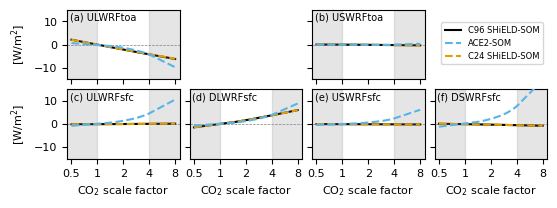

In [ ]:
fig, axes = faceted.faceted(
    2,
    4,
    width=5.5,
    internal_pad=(0.1, 0.1),
    left_pad=0.6,
    bottom_pad=0.5,
    top_pad=0.1,
    right_pad=0.1,
)

ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8 = axes


PANELS = {
    ax1: "ULWRFtoa",
    ax2: False,
    ax3: "USWRFtoa",
    ax4: False,
    ax5: "ULWRFsfc",
    ax6: "DLWRFsfc",
    ax7: "USWRFsfc",
    ax8: "DSWRFsfc",
}
COLORS = {
    REFERENCE: "black",
    ACE2_SOM: "C0",
    BASELINE: "C1",
}
LINE_STYLE = {
    REFERENCE: "-",
    BASELINE: "--",
    ACE2_SOM: "--",
}
LABELS = {REFERENCE: "C96 SHiELD-SOM", BASELINE: "C24 SHiELD-SOM", ACE2_SOM: "ACE2-SOM"}
ZORDER = {
    REFERENCE: 1,  # Start at 1 to allow for zero reference line at 0.
    BASELINE: 2,
    ACE2_SOM: 3,
}

for ax, name in PANELS.items():
    if name:
        for model, color in COLORS.items():
            delta_log_factor[name].sel(model=model).plot(
                ax=ax,
                color=color,
                label=LABELS[model],
                add_legend=False,
                ls=LINE_STYLE[model],
                zorder=ZORDER[model],
            )
    else:
        ax.set_visible(False)

for (ax, name), label in zip(
    PANELS.items(), ["a", None, "b", None, "c", "d", "e", "f"]
):
    if name:
        ax.axhline(0.0, color="gray", ls="--", lw=0.5, zorder=0)
        ax.annotate(
            f"({label}) {name}",
            xy=(0, 1),
            xytext=(2, -2),
            va="top",
            xycoords="axes fraction",
            textcoords="offset points",
            fontsize=7,
        )
        ax.set_ylabel("")
        ax.set_xticks(np.log(np.array([0.5, 1.0, 2.0, 4.0, 8.0])))
        ax.set_xticklabels(["0.5", "1", "2", "4", "8"])

        ax.set_title("")
        ax.axvspan(np.log(0.1), np.log(1.0), color="gray", alpha=0.2)
        ax.axvspan(np.log(4.0), np.log(10), color="gray", alpha=0.2)
        ax.set_ylim(-15, 15)

        # Set xlim such that gray areas are equal on either side 1 and 4.
        ax.set_xlim(np.log(4 / 9), np.log(9))

for ax in axes[4:]:
    ax.set_xlabel("CO$_2$ scale factor")

ax1.set_xlabel("")
ax3.set_xlabel("")

ax1.set_ylabel("[W/m$^2$]")
ax5.set_ylabel("[W/m$^2$]")
ax8.legend(
    fontsize=6,
    bbox_to_anchor=(1.0, 1.3),
    bbox_transform=ax8.transAxes,
    loc="lower right",
)

fig.savefig("figures/figure-10.png", dpi=200)
fig.savefig("figures/figure-10.pdf")